In [53]:
import pandas as pd
import numpy as np


from geneticalgorithm2 import geneticalgorithm2 as ga # for creating and running optimization model
from geneticalgorithm2 import Generation, AlgorithmParams # classes for comfortable parameters setting and getting
from geneticalgorithm2 import Crossover, Mutations, Selection # classes for specific mutation and crossover behavior
from geneticalgorithm2 import plot_pop_scores # for plotting population scores, if u want

In [54]:
# Load data into pandas DataFrame
df = pd.read_parquet("dataset/scaled_train_data.parquet")
classes = df["class"].unique()
#hard move data, so it's positive thus cosine measurements clamped to [0,1]
df.loc[:,df.columns != 'class'] -= df.loc[:,df.columns != 'class'].min()

MO_list = [df[df["class"] == c].mean(axis=0)[:-1].to_numpy() for c in classes ]

In [55]:
#only allow values in the original value range
#this is higly questionable
boundaries = [(min,max) for min,max in zip(df.min()[:-1],df.max()[:-1])]

[(0.0, 70.16041088543572), (0.0, 33.6460679839578), (0.0, 25.729922725065958), (0.0, 5.7072001843979905), (0.0, 3.9578969066551313), (0.0, 3.832658975798279), (0.0, 19.11261695562245), (0.0, 18.889935273075448), (0.0, 22.53818626099313), (0.0, 17.984287663488836), (0.0, 30.648128049171866), (0.0, 37.36485453244188)]


In [56]:
#class 0 = sitting, all the others are opposing
parameter_c = .4

def cos_measure(s:np.ndarray,t:np.ndarray):
    return np.dot(s,t)/(np.linalg.norm(s) *np.linalg.norm(t))


def F(s:np.ndarray):
    oppose_avg = 1 - (cos_measure(s,MO_list[1])+cos_measure(s,MO_list[2])+cos_measure(s,MO_list[3])+cos_measure(s,MO_list[4]))/4.
    num = cos_measure(s,MO_list[0]) + parameter_c * oppose_avg
    denom = 1. + parameter_c
    return (num)/denom

def costF(s:np.ndarray):
    return -F(s)

In [57]:
class Crossover(Crossover):
    #override original uniform function with bias
    @staticmethod
    def uniform(bias:float = 0.5):
        
        def func(x, y):
            ofs1, ofs2 = x.copy(),y.copy()
        
            ran = np.random.random(x.size) < bias
            ofs1[ran] = y[ran]
            ofs2[ran] = x[ran]
              
            return ofs1, ofs2
        
        return func
    

In [ ]:
test_matrice = [
    {"pop_size":20,"crossover_prob":.6,"mutation_prob":0.},
    {"pop_size":20,"crossover_prob":.6,"mutation_prob":0.01},
    {"pop_size":20,"crossover_prob":.6,"mutation_prob":0.1},
    {"pop_size":20,"crossover_prob":.9,"mutation_prob":0.01},
    {"pop_size":20,"crossover_prob":.9,"mutation_prob":0.01},
    {"pop_size":200,"crossover_prob":.6,"mutation_prob":0.},
    {"pop_size":200,"crossover_prob":.6,"mutation_prob":0.01},
    {"pop_size":200,"crossover_prob":.6,"mutation_prob":0.1},
    {"pop_size":200,"crossover_prob":.9,"mutation_prob":0.01},
    {"pop_size":200,"crossover_prob":.9,"mutation_prob":0.01},
]

In [61]:
for testcase in test_matrice:
    GA_modell = ga(costF,
                dimension=12,
                    variable_type=('real'),
                    variable_boundaries=boundaries,
                    algorithm_parameters=AlgorithmParams(
                        max_num_iteration = 1000,
                        max_iteration_without_improv=20,
                        population_size = 100,
                        mutation_probability = 0.1,
                        #elit_ratio = 0.01,
                        parents_portion = 0.3,
                        crossover_type = Crossover.mixed(alpha=.6),
                        #crossover_type = Crossover.uniform(bias=.6),
                        mutation_type = 'uniform_by_center',
                        #selection_type = 'roulette',
                        selection_type = Selection.tournament(tau=4),
                        max_iteration_without_improv = None
                        ))
    # all of this parameters are default
    result = GA_modell.run(no_plot=True)
    testcase["result"] = result


Set: Average time of function evaluating (secs): 0.0001316356658935547 (total = 0.013163566589355469)

Best score before optimization: -0.7036619799908189
____________________ 0.2% GA is running...2 gen from 1000...best value = -0.7067306087240361

                                                                                                                                                                                                        
 The best found solution:
 [25.39324365 13.11841298 15.03518911  2.85650065  2.31249112  3.10962995
  9.94955579 10.50736197 11.25054934 15.64916738 19.84923834 27.72382822]

 Objective function:
 -0.7150139094342285

 Used generations: 1000
 Used time: 22.4 seconds


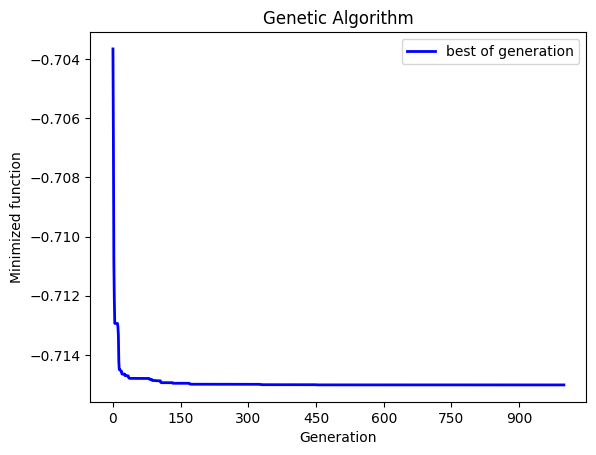

In [60]:
# best solution
print(" best score:",F(result.variable))

for i in range(5):
    print(f"cosine({i}):",cos_measure(result.variable,MO_list[i]))


 best score: 0.7150060940109902
cosine(0): 0.9994736318450007
cosine(1): 0.996312884079207
cosine(2): 0.9967019984403727
cosine(3): 0.9961928295029607
cosine(4): 0.9954432902736031
